In this notebook we fit many time distributions, making the assumption that we have the whole data (which is not true). For a more valid approximation, check [probability_distributions_censored.ipynb](probability_distributions_censored.ipynb) notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

sns.set_style('whitegrid')

import sys
sys.path.insert(0, "..")

from covid_simulation.fit_distributions.plot import distplot
from covid_simulation.fit_distributions.uncensored import *

In [3]:
# Cargamos los datos de la Junta a fecha 29 marzo
FECHA = "0329"
datos = pd.read_csv('../data/'+ FECHA +'_covid_andalucia_private.csv', index_col=0)

# Convertimos a fecha algunas columnas
list_col_dates = ["alta", "declaracion", "ingreso", "resultado", "sintomas"]

for col in list_col_dates:
    datos[col] = pd.to_datetime(datos[col], format="%Y-%m-%d")

datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5405 entries, 0 to 5404
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   edad             5405 non-null   int64         
 1   evolucion        5405 non-null   object        
 2   alta             461 non-null    datetime64[ns]
 3   declaracion      5405 non-null   datetime64[ns]
 4   ingreso          2713 non-null   datetime64[ns]
 5   sintomas         3802 non-null   datetime64[ns]
 6   resultado        5360 non-null   datetime64[ns]
 7   hospital         5405 non-null   bool          
 8   fueralaboral     5405 non-null   bool          
 9   hospitalingreso  2717 non-null   object        
 10  identificador    5405 non-null   int64         
 11  provincia        5405 non-null   object        
 12  sexo             5404 non-null   float64       
 13  unidadingreso    5405 non-null   object        
 14  uci              1147 non-null   float64

# Síntomas a hospitalización

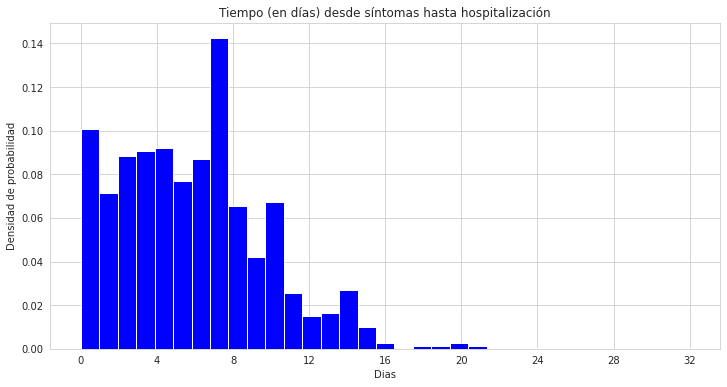

In [4]:
sintom_hosp = (datos["ingreso"] - datos["sintomas"]).dt.days
# Descartamos a aquellos pacientes que ya estaban hospitalizados
# antes de padecer sintomas (exigimos días > 0)
sintom_hosp = sintom_hosp[sintom_hosp >= 0]
distplot(sintom_hosp, title="Tiempo (en días) desde síntomas hasta hospitalización")

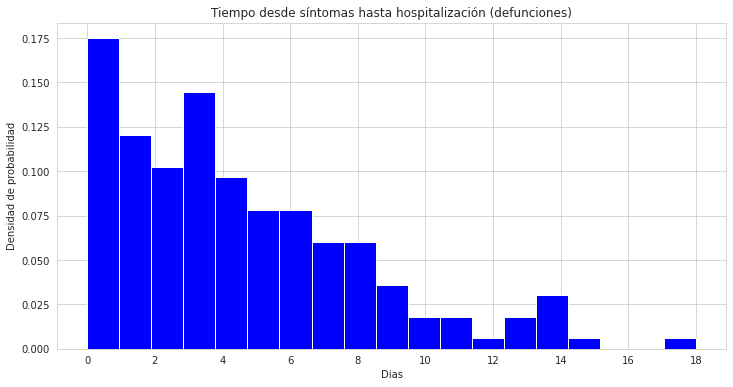

In [5]:
# Nos quedamos sólo con los pacientes que mueren
mask_death = datos["evolucion"] == "defuncion"
distplot(sintom_hosp[mask_death], title="Tiempo desde síntomas hasta hospitalización (defunciones)")

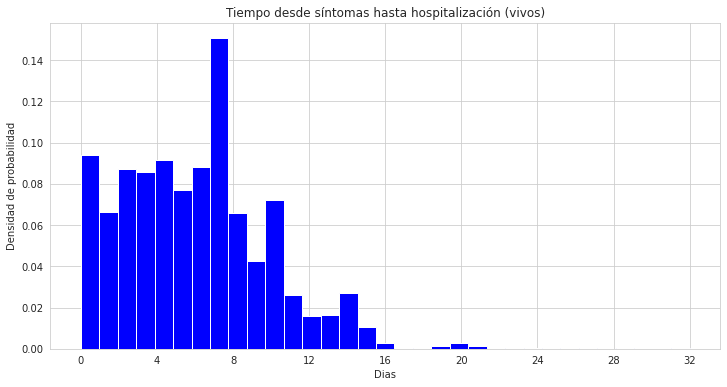

In [6]:
# Ahora al contrario
distplot(sintom_hosp[~mask_death], title="Tiempo desde síntomas hasta hospitalización (vivos)")

Hipótesis nula: los datos provienen de una distribución lognorm
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la lognorm dada
{'s': 0.715017150137069, 'scale': 5.050366458886769}


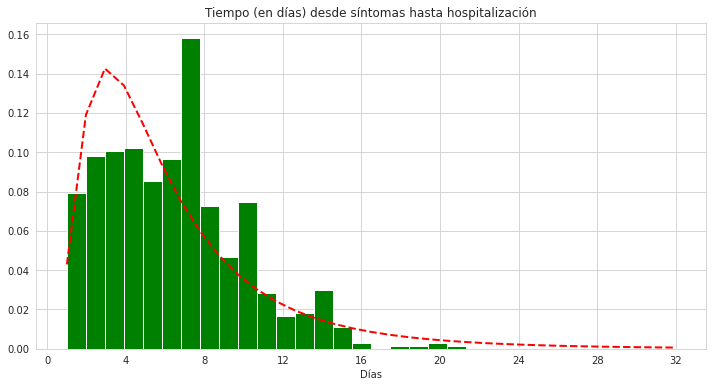

In [7]:
kwargs = {"s": .5,
         "scale": 2}

params = fit_lognorm(sintom_hosp, **kwargs,
                     title="Tiempo (en días) desde síntomas hasta hospitalización")
non_parametric_test(sintom_hosp, "lognorm", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.6684996653892123, 'scale': 6.746889525770571}


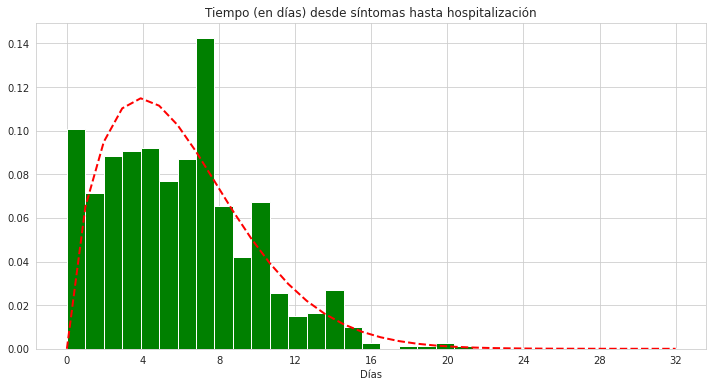

In [8]:
kwargs = {"c": 1.25,
         "scale": 3}

params = fit_weibull(sintom_hosp, **kwargs,
                     title="Tiempo (en días) desde síntomas hasta hospitalización")
non_parametric_test(sintom_hosp, "weibull_min", params.values())

print(params)

# Hospitalización a defunción

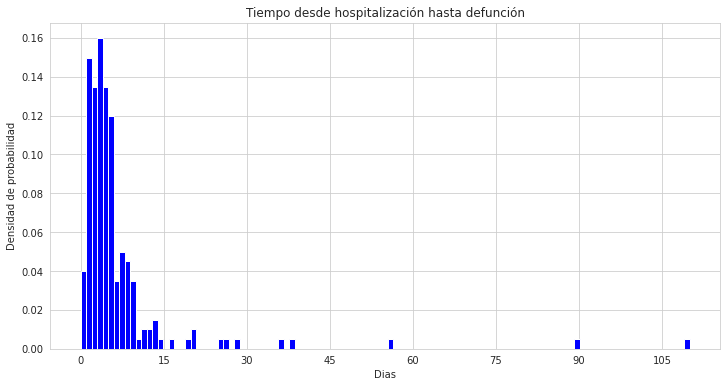

In [9]:
# Sólo queremos a los pacientes que recibieron el alta por defunción
hosp_defun = (datos["alta"] - datos["ingreso"]).dt.days
hosp_defun = hosp_defun[hosp_defun >= 0]
distplot(hosp_defun[mask_death], title="Tiempo desde hospitalización hasta defunción")

## ¿100 días de hospitalización?
Veamos aquellos pacientes que pasaron más de 25 días desde su ingreso hasta su defunción.

Observamos que en los casos donde hay presencia de síntomas, esta es más de un mes después de ser hospitalizados

**Solución:** eliminamos a todos aquellos casos que fueron hospitalizados antes de presentar síntomas.

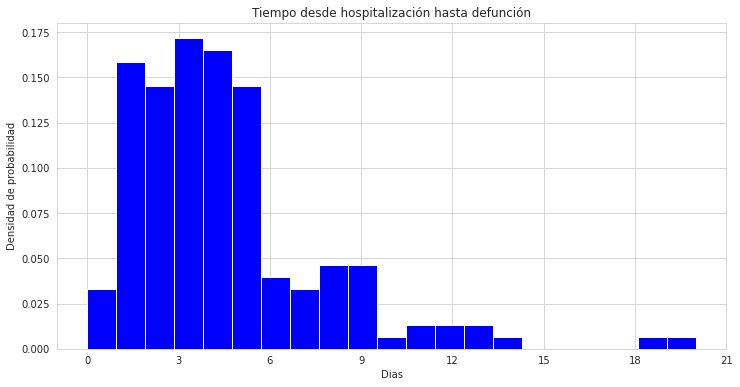

In [10]:
mask2 = (datos.loc[mask_death, "alta"] - datos.loc[mask_death, "ingreso"]).dt.days > 25

mask_covid = datos["sintomas"] <= datos["ingreso"]

hosp_defun = datos[mask_death & mask_covid]
hosp_defun = (hosp_defun["alta"] - hosp_defun["ingreso"]).dt.days
hosp_defun = hosp_defun[hosp_defun >= 0]

distplot(hosp_defun, title="Tiempo desde hospitalización hasta defunción")

Hipótesis nula: los datos provienen de una distribución lognorm
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la lognorm dada
{'s': 0.7277644480643075, 'scale': 3.435750220215631}


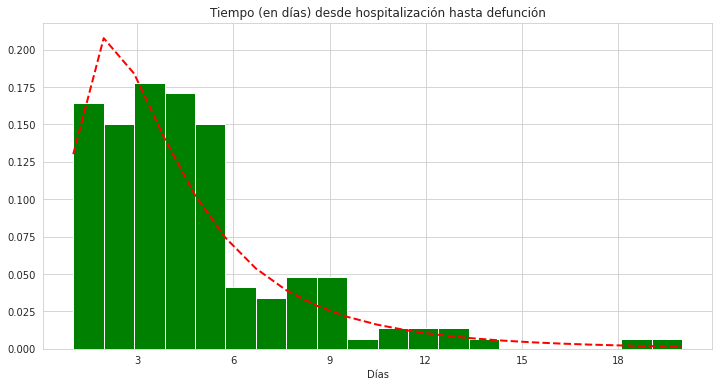

In [11]:
kwargs = {"s": 0,
         "scale": 1.2}

params = fit_lognorm(hosp_defun, **kwargs,
                     title="Tiempo (en días) desde hospitalización hasta defunción")
non_parametric_test(hosp_defun, "lognorm", params.values())

print(params)

In [12]:
kwargs = {"c": 1.25,
         "scale": 15.86}

params = fit_weibull(hosp_defun, **kwargs,
                     title="Tiempo (en días) desde hospitalización hasta defunción")
non_parametric_test(hosp_defun, "weibull_min", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.4516268803512926, 'scale': 4.833385618406849}


In [13]:
kwargs = {"c": 1.25,
         "scale": 15.86}

params = fit_weibull(hosp_defun, **kwargs,
                     title="Tiempo (en días) desde hospitalización hasta defunción")
non_parametric_test(hosp_defun, "weibull_min", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.4516268803512926, 'scale': 4.833385618406849}


# Síntomas a positivo

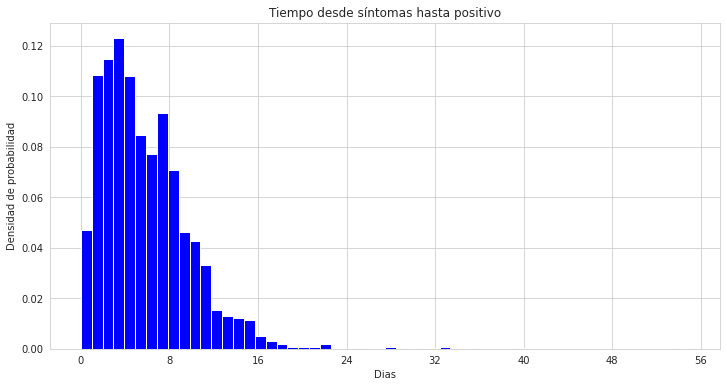

In [14]:
# Sólo queremos a los pacientes que recibieron el alta por defunción
sintom_result = (datos["resultado"] - datos["sintomas"]).dt.days
sintom_result = sintom_result[sintom_result >= 0]
distplot(sintom_result, title="Tiempo desde síntomas hasta positivo")

In [15]:
kwargs = {"s": 0,
         "scale": 1}

params = fit_lognorm(sintom_result, **kwargs,
                     title="Tiempo (en días) desde síntomas hasta positivo")
non_parametric_test(sintom_result, "lognorm", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución lognorm
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la lognorm dada
{'s': 0.7638627157543293, 'scale': 4.370761689834008}


In [16]:
kwargs = {"c": 1.25,
         "scale": 15.86}

params = fit_weibull(sintom_result, **kwargs,
                     title="Tiempo (en días) desde síntomas hasta positivo")
non_parametric_test(sintom_result, "weibull_min", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.4813330774306734, 'scale': 6.143947613720869}


# Síntomas a defunción

In [17]:
# Sólo queremos a los pacientes que recibieron el alta por defunción
sintom_defun = (datos["alta"] - datos["sintomas"]).dt.days
sintom_defun = sintom_defun[sintom_defun >= 0]
distplot(sintom_defun[mask_death], title="Tiempo desde síntomas hasta defunción")

Hipótesis nula: los datos provienen de una distribución lognorm
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la lognorm dada
{'s': 0.7004981718270248, 'scale': 8.034725349487294}


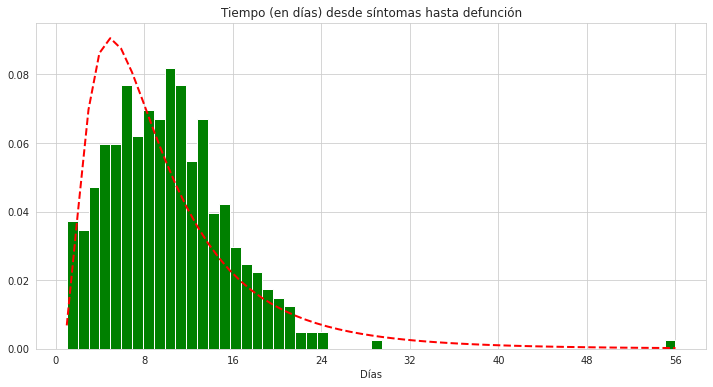

In [18]:
kwargs = {"s": 0,
         "scale": 1}

params = fit_lognorm(sintom_defun, **kwargs,
                     title="Tiempo (en días) desde síntomas hasta defunción")
non_parametric_test(sintom_defun, "lognorm", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.7896268064219525, 'scale': 10.976605777950397}


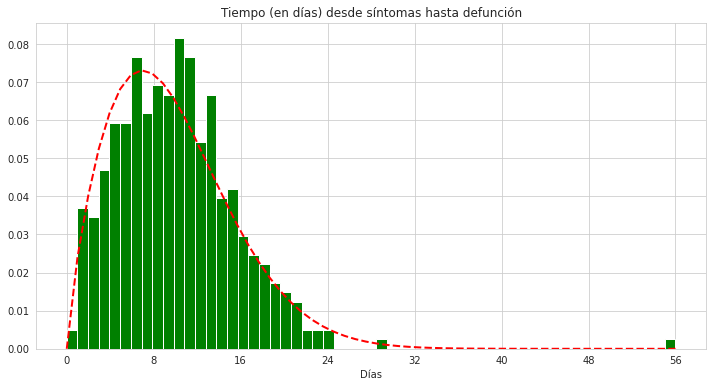

In [19]:
kwargs = {"c": 1.25,
         "scale": 15.86}

params = fit_weibull(sintom_defun, **kwargs,
                     title="Tiempo (en días) desde síntomas hasta defunción")
non_parametric_test(sintom_defun, "weibull_min", params.values())

print(params)

# LOS no UCI
Tiempo de estancia en el hospital para pacientes que no pasan por la UCI.

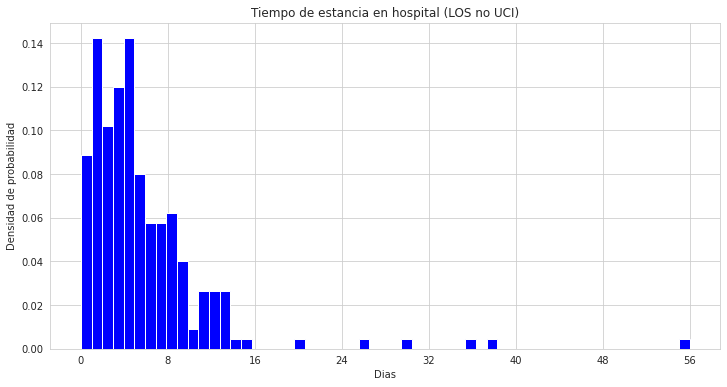

In [20]:
# Tomamos a los pacientes que ingresaron en hospital
mask_hosp = ~datos["ingreso"].isna()

# Descartamos aquellos que pasaron por la UCI
mask_no_uci = datos["uci"].fillna(1) == 0

hosp_los = datos[mask_hosp & mask_no_uci]
hosp_los = (hosp_los["alta"] - hosp_los["ingreso"]).dt.days
hosp_los = hosp_los[hosp_los >= 0]
distplot(hosp_los, title="Tiempo de estancia en hospital (LOS no UCI)")

In [21]:
kwargs = {"s": 0,
         "scale": 1}

params = fit_lognorm(hosp_los, **kwargs,
                     title="Tiempo de estancia en hospital (LOS no UCI)")
non_parametric_test(hosp_los, "lognorm", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución lognorm
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la lognorm dada
{'s': 0.8421780465013519, 'scale': 4.042673363465128}


Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.1389829554909232, 'scale': 5.67910839498734}


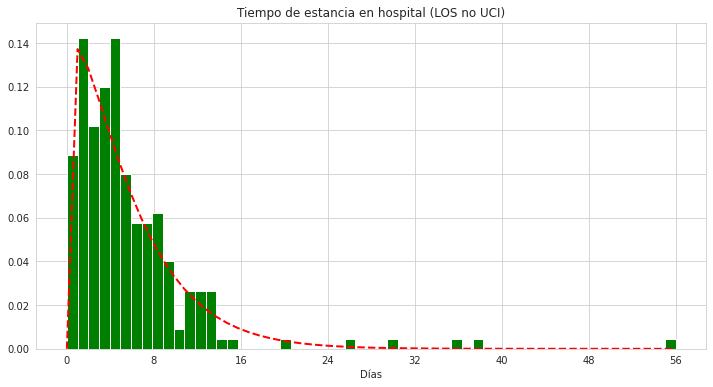

In [22]:
kwargs = {"c": 1.25,
         "scale": 15.86}

params = fit_weibull(hosp_los, **kwargs,
                     title="Tiempo de estancia en hospital (LOS no UCI)")
non_parametric_test(hosp_los, "weibull_min", params.values())

print(params)

## Cortamos a 31 días
Probemos a quitar los casos que han pasado más de un mes en el hospital.

Hipótesis nula: los datos provienen de una distribución lognorm
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la lognorm dada
{'s': 0.7983108145783494, 'scale': 3.9065515973996847}


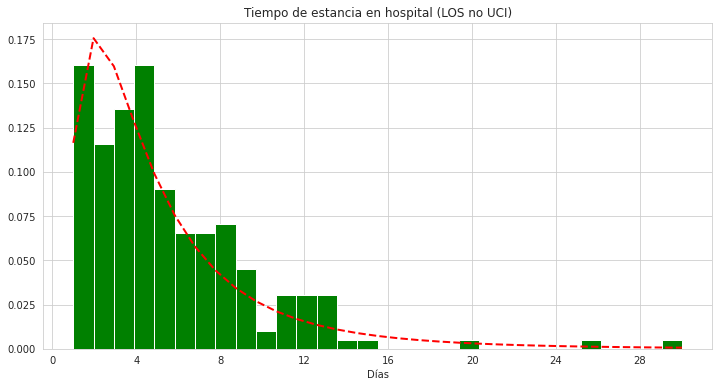

In [23]:
kwargs = {"s": 0,
         "scale": 1}

params = fit_lognorm(hosp_los[hosp_los <= 31], **kwargs,
                     title="Tiempo de estancia en hospital (LOS no UCI)")
non_parametric_test(hosp_los, "lognorm", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.3386189328893368, 'scale': 5.432270536490794}


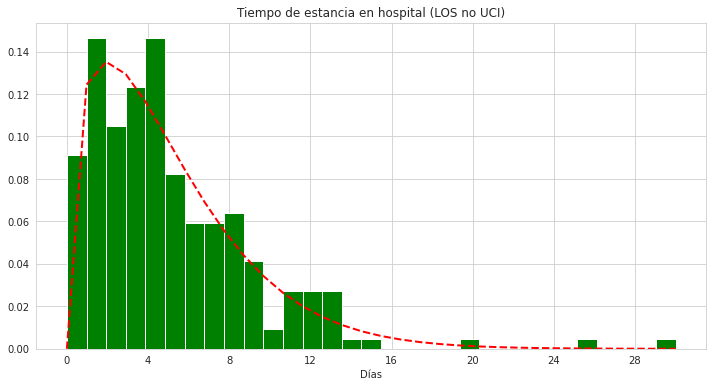

In [24]:
kwargs = {"c": 1.25,
         "scale": 15.86}

params = fit_weibull(hosp_los[hosp_los <= 31], **kwargs,
                     title="Tiempo de estancia en hospital (LOS no UCI)")
non_parametric_test(hosp_los, "weibull_min", params.values())

print(params)

# LOS UCI
Tiempo de estancia en el hospital para pacientes que pasan por la UCI.

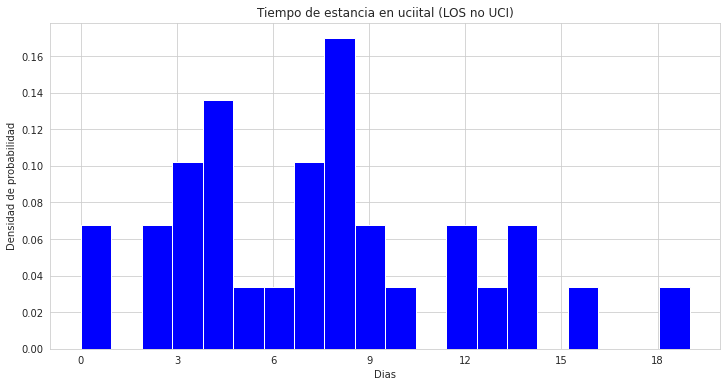

In [25]:
# Tomamos a los pacientes que ingresaron en uci
mask_uci = ~datos["ingreso"].isna()

# Descartamos aquellos que pasaron por la UCI
mask_uci = datos["uci"].fillna(0) == 1

uci_los = datos[mask_uci & mask_uci]
uci_los = (uci_los["alta"] - uci_los["ingreso"]).dt.days
uci_los = uci_los[uci_los >= 0]
distplot(uci_los, title="Tiempo de estancia en uciital (LOS no UCI)")

In [26]:
kwargs = {"s": 0,
         "scale": 1}

params = fit_lognorm(uci_los, **kwargs,
                     title="Tiempo de estancia en uciital (LOS no UCI)")
non_parametric_test(uci_los, "lognorm", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución lognorm
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la lognorm dada
{'s': 0.6036815529858983, 'scale': 6.683677738227416}


In [27]:
kwargs = {"c": 1.25,
         "scale": 15.86}

params = fit_weibull(uci_los, **kwargs,
                     title="Tiempo de estancia en uciital (LOS no UCI)")
non_parametric_test(uci_los, "weibull_min", params.values())

print(params)

Hipótesis nula: los datos provienen de una distribución weibull_min
Con un pvalor de 0.0 rechazamos H0 a un nivel de significación de 0.05
Los datos no se ajustan a la weibull_min dada
{'c': 1.9102127655935721, 'scale': 8.75319063784631}
